In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-pines-hyperspectral-dataset/indianpinearray.npy
/kaggle/input/indian-pines-hyperspectral-dataset/IPgt.npy


In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

The paper titled **"[Hyperspectral Image Classification Based on Multi-Scale Convolutional Features and Multi-Attention Mechanisms (MSCF-MAM)](https://www.mdpi.com/2072-4292/16/12/2185)"** introduces a novel model for hyperspectral image (HSI) classification. The authors combine multi-scale convolutional features and multi-attention mechanisms to improve the classification accuracy of HSIs, addressing limitations of traditional CNNs and Transformer models.

**Multi-Scale Convolutional Features:** The model employs multi-scale 3D convolution blocks to capture spatial features across various scales in HSIs.

**Pyramid Squeeze Attention (PSA):** This mechanism enhances spatial-spectral feature extraction by leveraging multi-scale pyramid structures and attention weights to strengthen feature representations.

**Transformer Encoder:** It captures long-range dependencies and refines internal feature correlations using the multi-head self-attention (MHSA) mechanis

#### . HSI Data Pre-Processing
- **Purpose**: To reduce dimensionality and alleviate computational complexity while preserving essential spectral information.

#### . Multi-Scale Convolutional Feature Extraction
- **Objective**: To capture spatial features at multiple scales, enhancing the model's ability to represent diverse image characteristics.

#### . Feature Enhancement Based on Pyramid Squeeze Attention
- **Logic**: To improve the richness of feature representation by dynamically adjusting attention weights, ensuring important features are emphasized.

#### . Transformer Encoder
- **Purpose**: To capture long-range dependencies among features, allowing for deeper semantic understanding and improved classification accuracy.


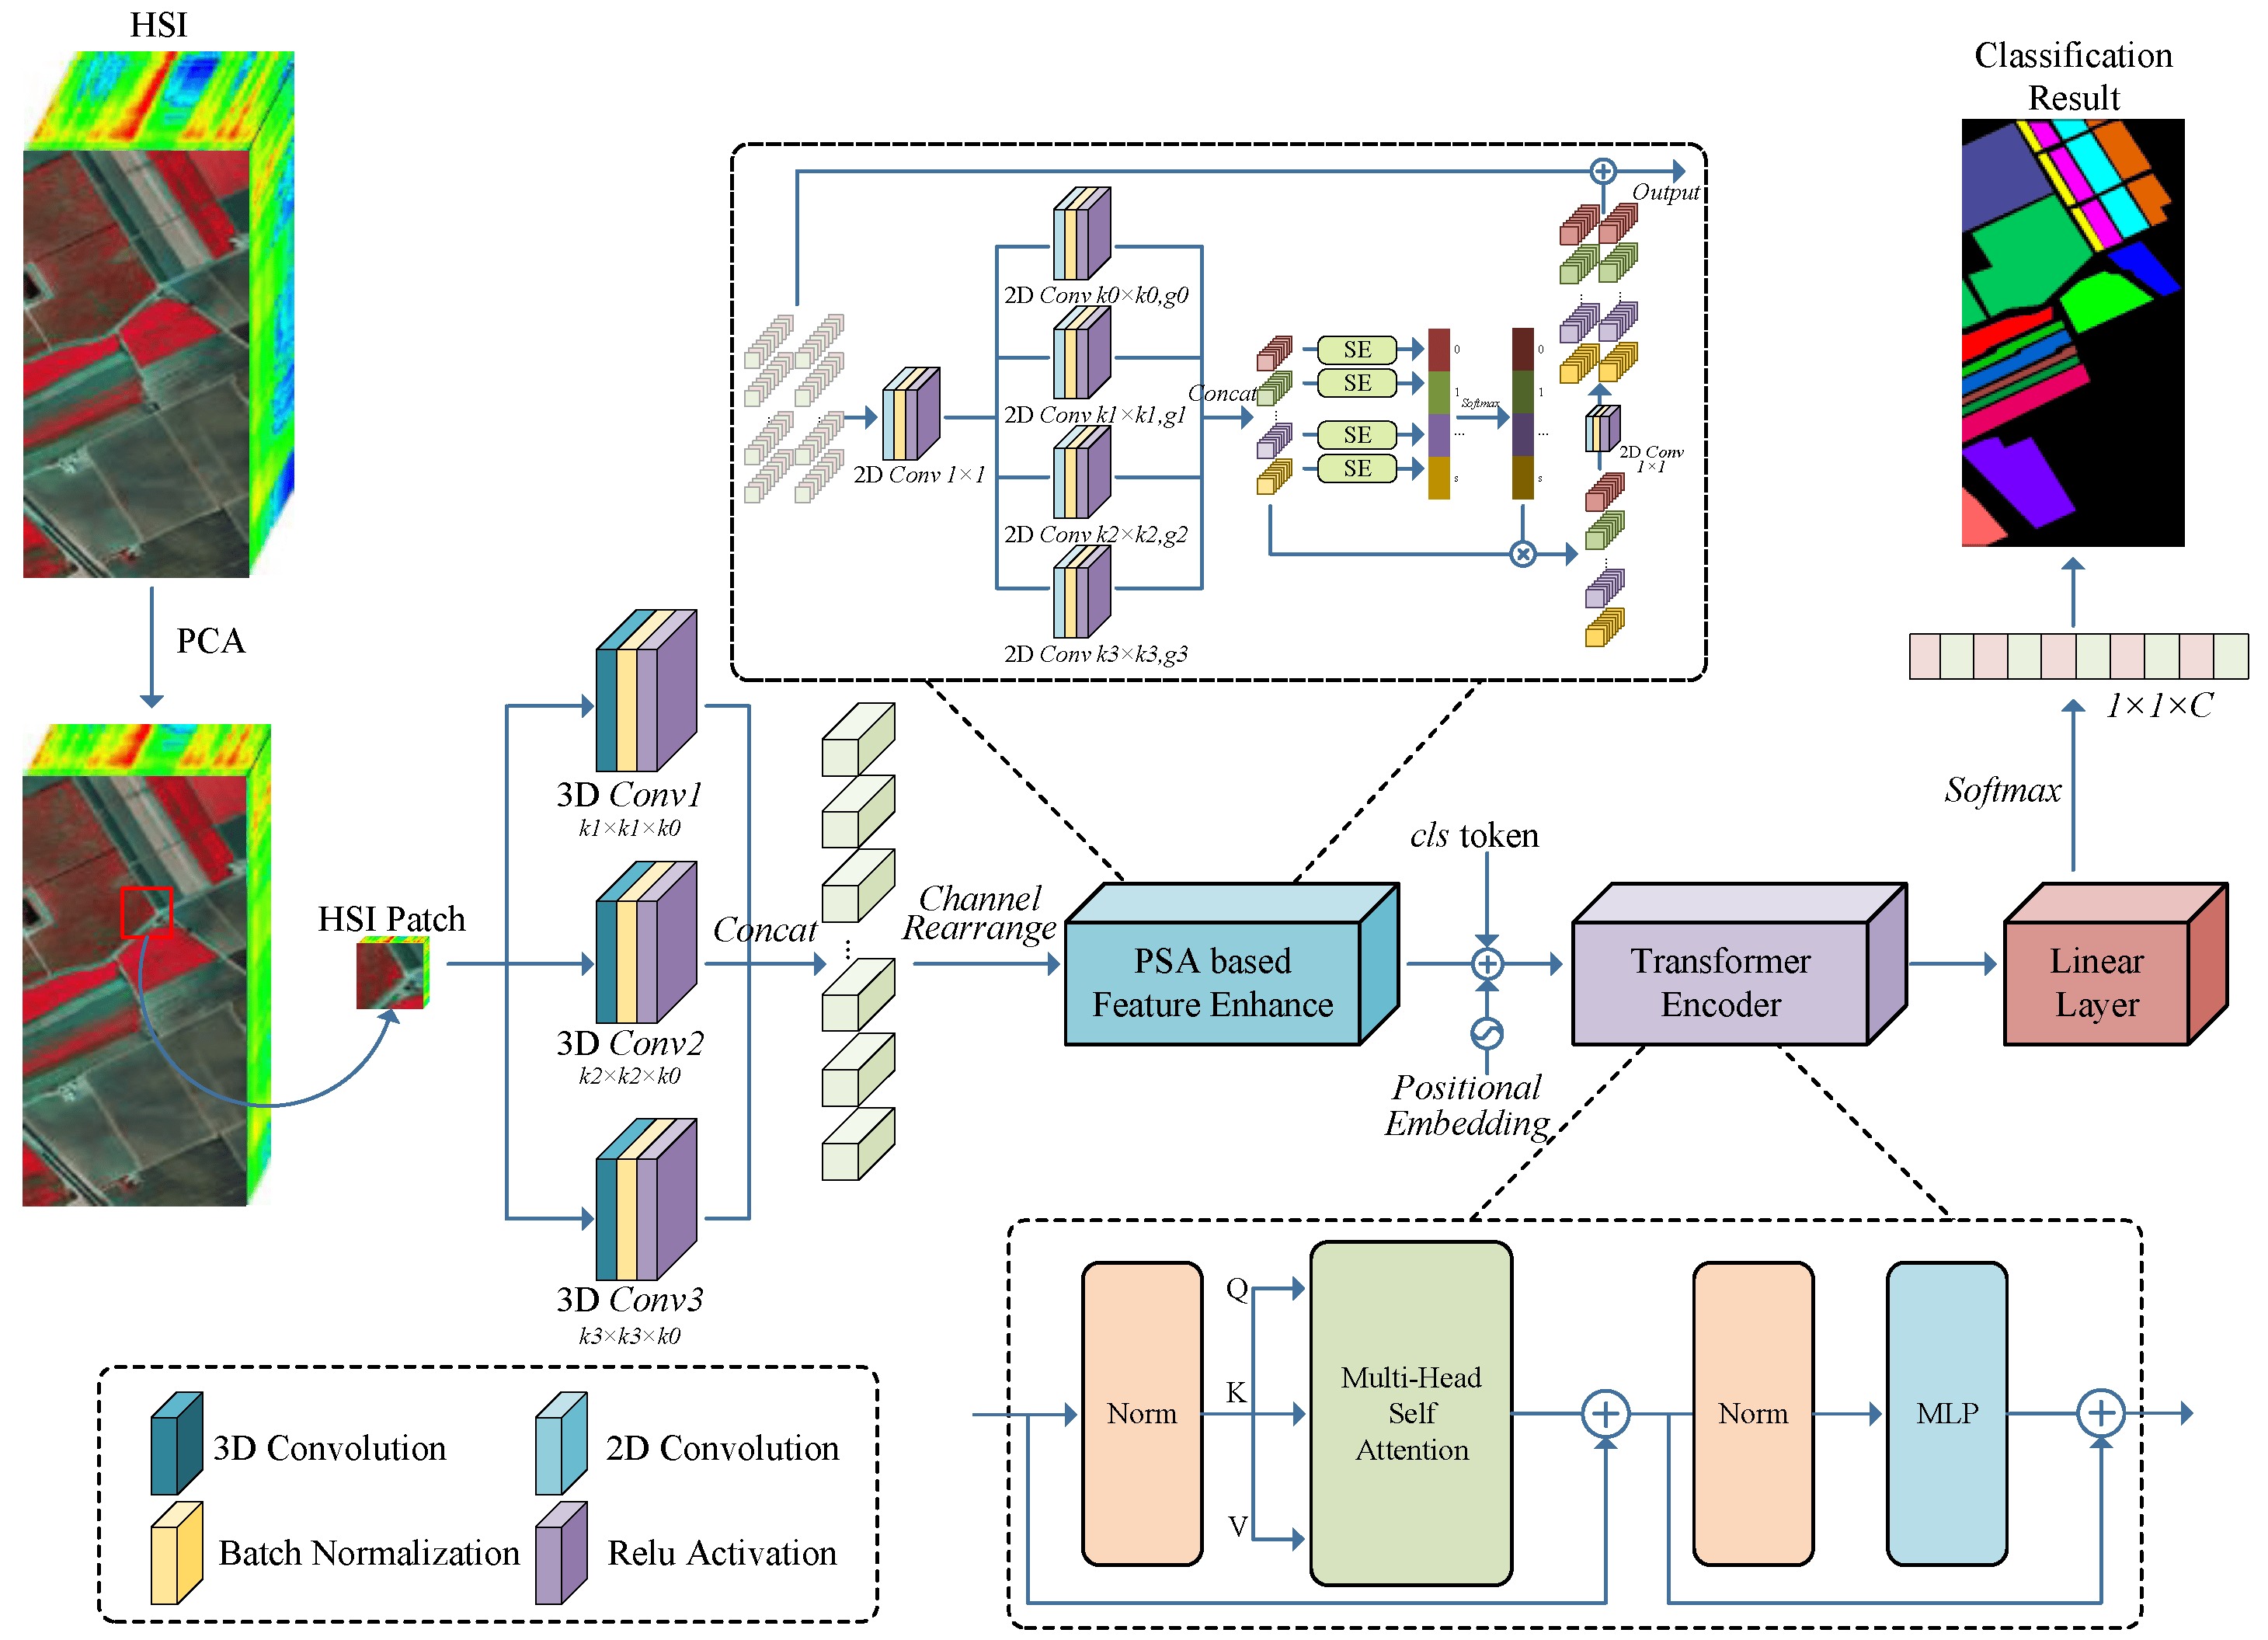

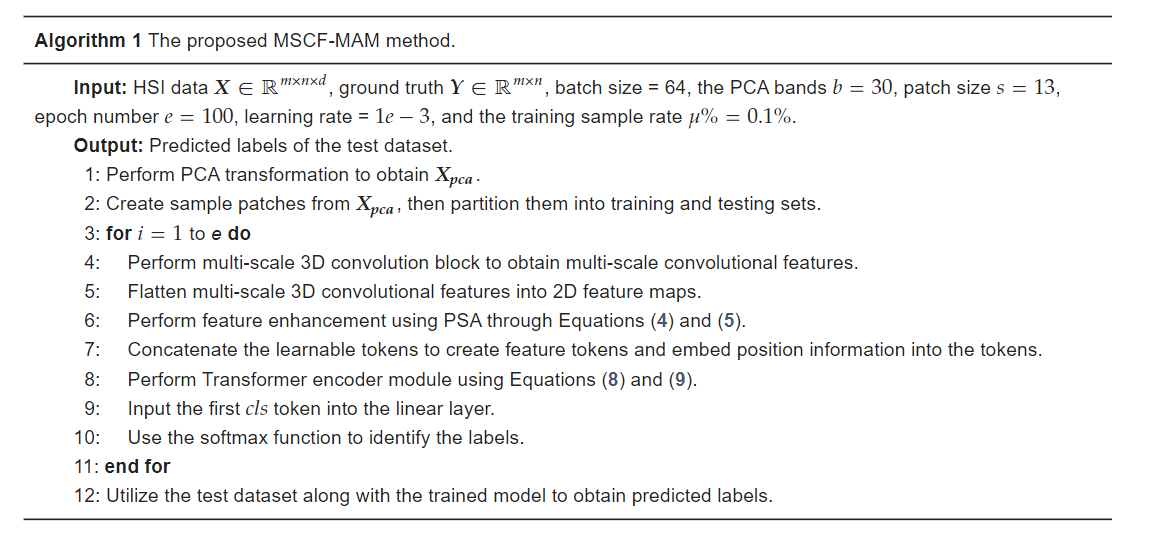

Hyperspectral Data Shape: (145, 145, 200)
Ground Truth Labels Shape: (145, 145)


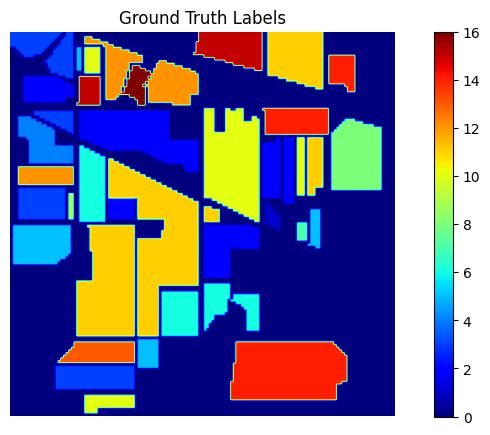

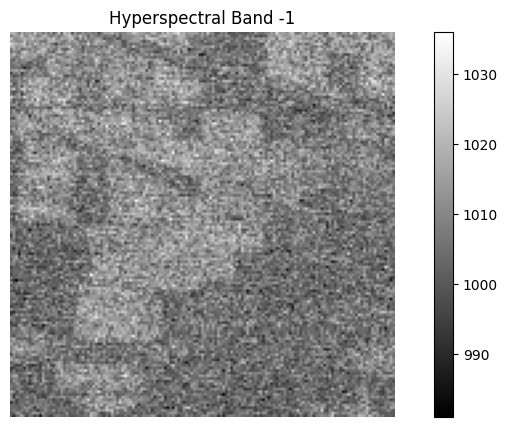

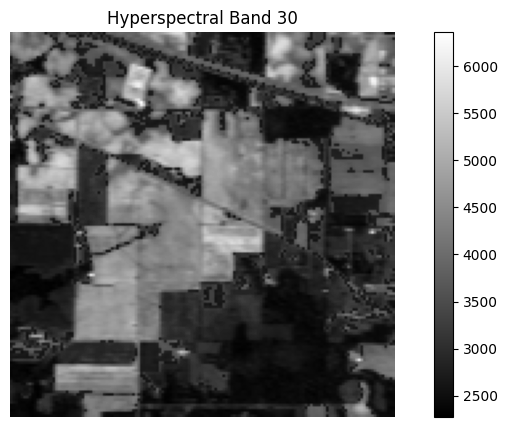

In [17]:
data_path = '/kaggle/input/indian-pines-hyperspectral-dataset/indianpinearray.npy'  
label_path = '/kaggle/input/indian-pines-hyperspectral-dataset/IPgt.npy'  

hyperspectral_data = np.load(data_path)
ground_truth_labels = np.load(label_path)

print("Hyperspectral Data Shape:", hyperspectral_data.shape)
print("Ground Truth Labels Shape:", ground_truth_labels.shape)

plt.figure(figsize=(10, 5))
plt.imshow(ground_truth_labels, cmap='jet')
plt.title('Ground Truth Labels')
plt.axis('off')
plt.colorbar()
plt.show()

band_index = -1
plt.figure(figsize=(10, 5))
plt.imshow(hyperspectral_data[:, :, band_index], cmap='gray')
plt.title(f'Hyperspectral Band {band_index}')
plt.axis('off')
plt.colorbar()
plt.show()

band_index = 30
plt.figure(figsize=(10, 5))
plt.imshow(hyperspectral_data[:, :, band_index], cmap='gray')
plt.title(f'Hyperspectral Band {band_index}')
plt.axis('off')
plt.colorbar()
plt.show()

### Implementation

> 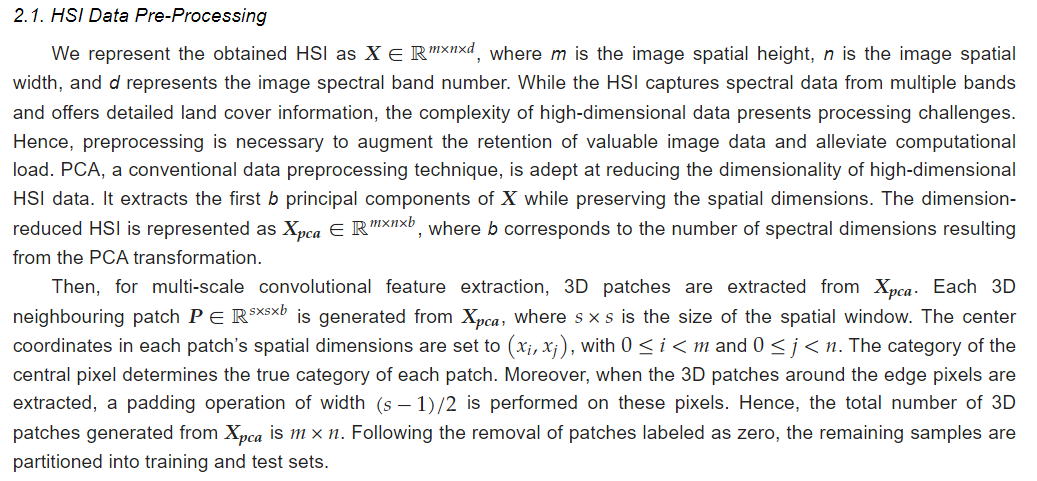

> 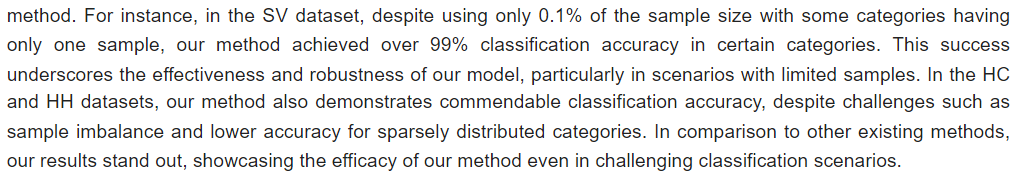

In [18]:
batch_size = 64
pca_bands = 30
patch_size = 13
num_epochs = 100
learning_rate = 1e-3
sample_rate = 0.1 

def apply_pca(data, n_components):
    reshaped_data = data.reshape(-1, data.shape[2])  # reshape to (m*n, d)
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(reshaped_data)
    return pca_result.reshape(data.shape[0], data.shape[1], n_components)  

hyperspectral_data_pca = apply_pca(hyperspectral_data, pca_bands)

In [19]:
hyperspectral_data_pca.shape

(145, 145, 30)

In [20]:
def create_patches(data, labels, patch_size):
    m, n, d = data.shape
    half_patch = patch_size // 2
    
    #padding
    padded_data = np.pad(data, ((half_patch, half_patch), (half_patch, half_patch), (0, 0)), mode='reflect')
    padded_labels = np.pad(labels, ((half_patch, half_patch), (half_patch, half_patch)), mode='reflect')
    
    patches = []
    patch_labels = []
    im_labels = []
    
    for i in range(m):
        for j in range(n):
            patch = padded_data[i:i + patch_size, j:j + patch_size, :]
            patch_l = padded_labels[i + half_patch, j + half_patch]
            
            patches.append(patch)
            patch_labels.append(patch_l)
            im_labels.append(padded_labels[i:i + patch_size, j:j + patch_size])
    
    patches = np.array(patches)
    patch_labels = np.array(patch_labels)
    im_labels = np.array(im_labels)
    
    remove zero-labeled patches
    non_zero_indices = patch_labels != 0
    patches = patches[non_zero_indices]
    patch_labels = patch_labels[non_zero_indices]
    im_labels = im_labels[non_zero_indices]  
    
    return patches, patch_labels, im_labels



In [21]:
patches, patch_labels, image_labels = create_patches(hyperspectral_data_pca, ground_truth_labels, patch_size)

In [22]:
patches.shape

(21025, 13, 13, 30)

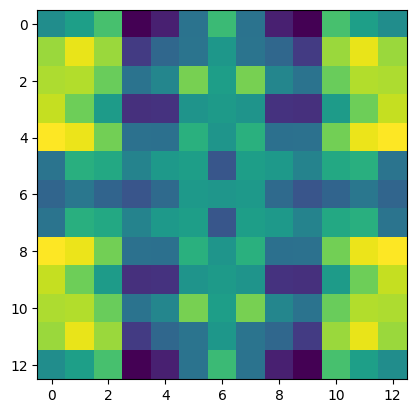

3

In [23]:
plt.imshow(patches[-1][:, :, :1])
plt.show()
patch_labels[0]

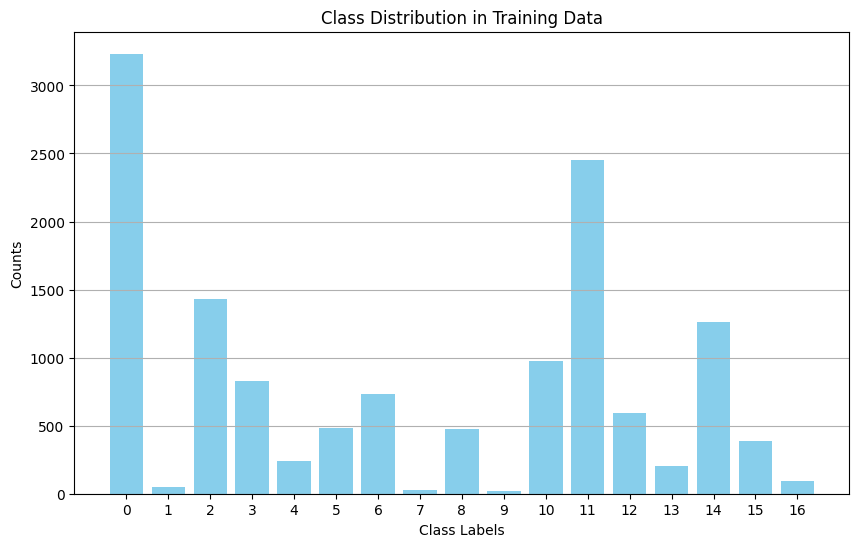

In [27]:
unique_classes, counts = np.unique(patch_labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Counts')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_classes)
plt.grid(axis='y')
plt.show()

In [28]:
train_size = int(len(patches) * sample_rate)
X_train, X_test, y_train, y_test = train_test_split(patches, patch_labels, train_size=train_size, stratify=patch_labels)


X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 2, 1)  # Shape: [N, C, H, W]
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 2, 1)  # Shape: [N, C, H, W]
y_test = torch.tensor(y_test, dtype=torch.long)

>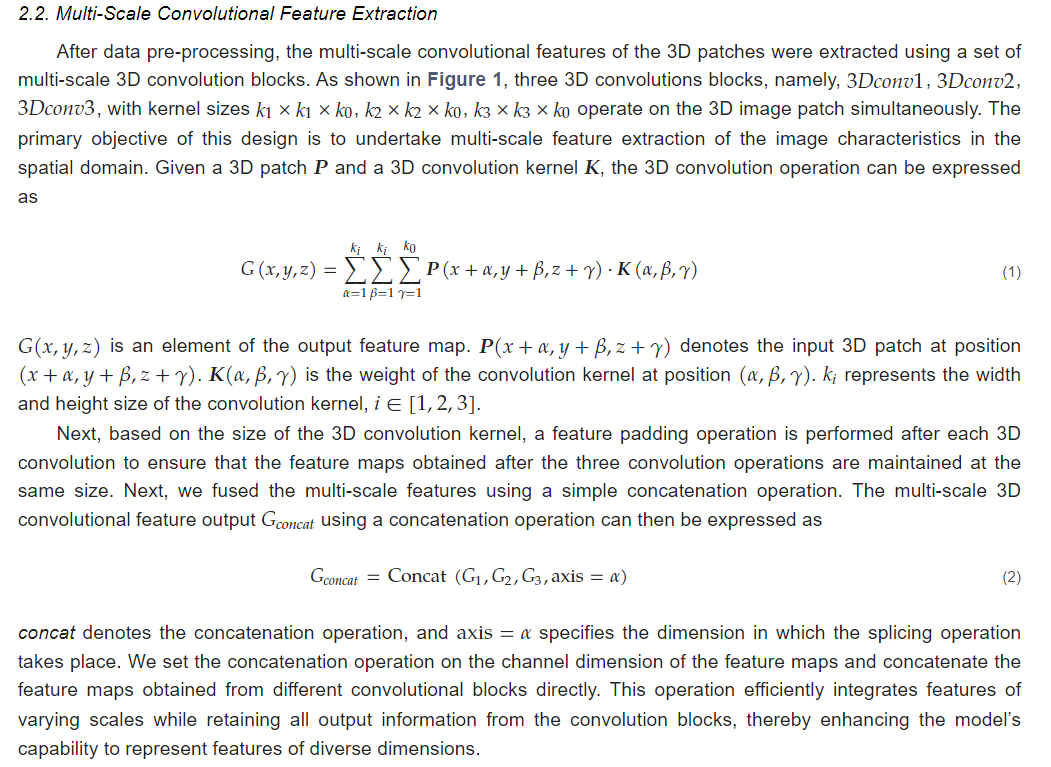

<ol>
    <code>
        Output size = ((D - K + 2P) / S + 1) × ((H - K + 2P) / S + 1) × ((W - K + 2P) / S + 1)
    </code>
    <li>
        <strong>conv1</strong>:
        <ul>
            <li>Kernel: (3, 3, 3), Padding: 1</li>
            <li>Output size: 
                <code>
                    (D - 3 + 2 * 1) / 1 + 1 × (H - 3 + 2 * 1) / 1 + 1 × (W - 3 + 2 * 1) / 1 + 1
                </code>
            </li>
        </ul>
    </li>
    <li>
        <strong>conv2</strong>:
        <ul>
            <li>Kernel: (5, 5, 3), Padding: 2</li>
            <li>Output size: 
                <code>
                    (D - 5 + 2 * 2) / 1 + 1 × (H - 5 + 2 * 2) / 1 + 1 × (W - 3 + 2 * 2) / 1 + 1
                </code>
            </li>
        </ul>
    </li>
    <li>
        <strong>conv3</strong>:
        <ul>
            <li>Kernel: (7, 7, 3), Padding: 3</li>
            <li>Output size: 
                <code>
                    (D - 7 + 2 * 3) / 1 + 1 × (H - 7 + 2 * 3) / 1 + 1 × (W - 3 + 2 * 3) / 1 + 1
                </code>
            </li>
        </ul>
    </li>
</ol>

In [30]:
class MSCFE(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(MSCFE, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=input_channels, out_channels=64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv2 = nn.Conv3d(in_channels=input_channels, out_channels=64, kernel_size=(5, 5, 3), padding=(2, 2, 1))  
        self.conv3 = nn.Conv3d(in_channels=input_channels, out_channels=64, kernel_size=(7, 7, 3), padding=(3, 3, 1))

    def forward(self, x):
        #Multi-Scale CFE
        #print(x.shape)
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        out3 = self.conv3(x)
        #Concat Part
        out = torch.cat((out1, out2, out3), dim=1)
        out = out.squeeze(2)
        return out

> 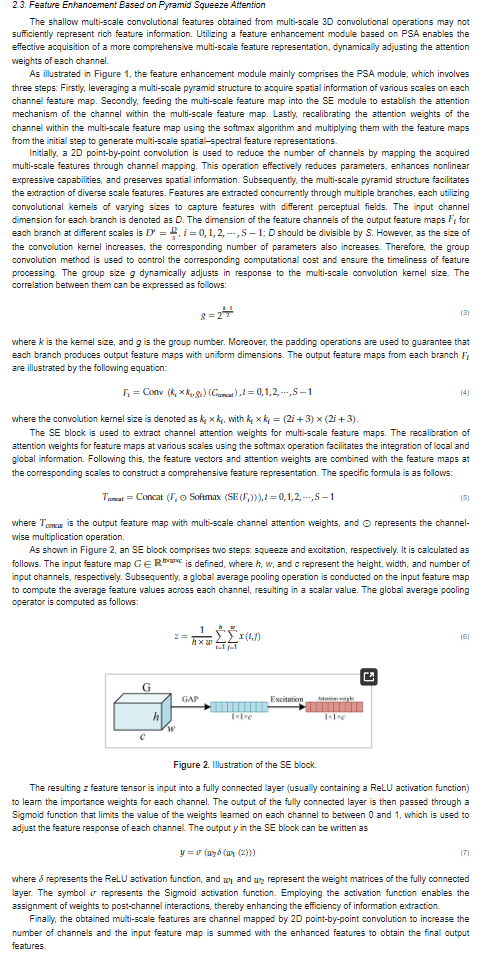

> 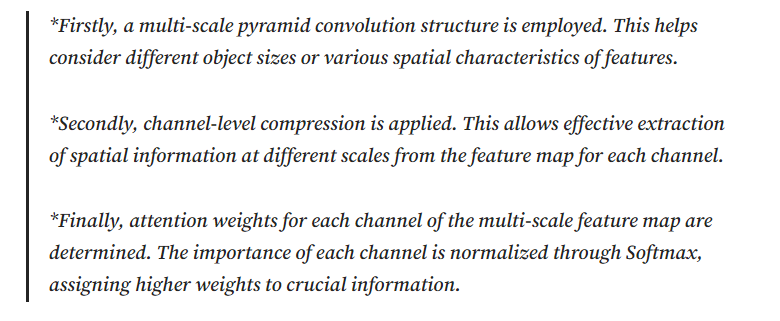 

> https://medium.com/@hichengkang/paper-review-epsanet-an-efficient-pyramid-squeeze-attention-block-on-convolutional-neural-c4a3b2095b4f

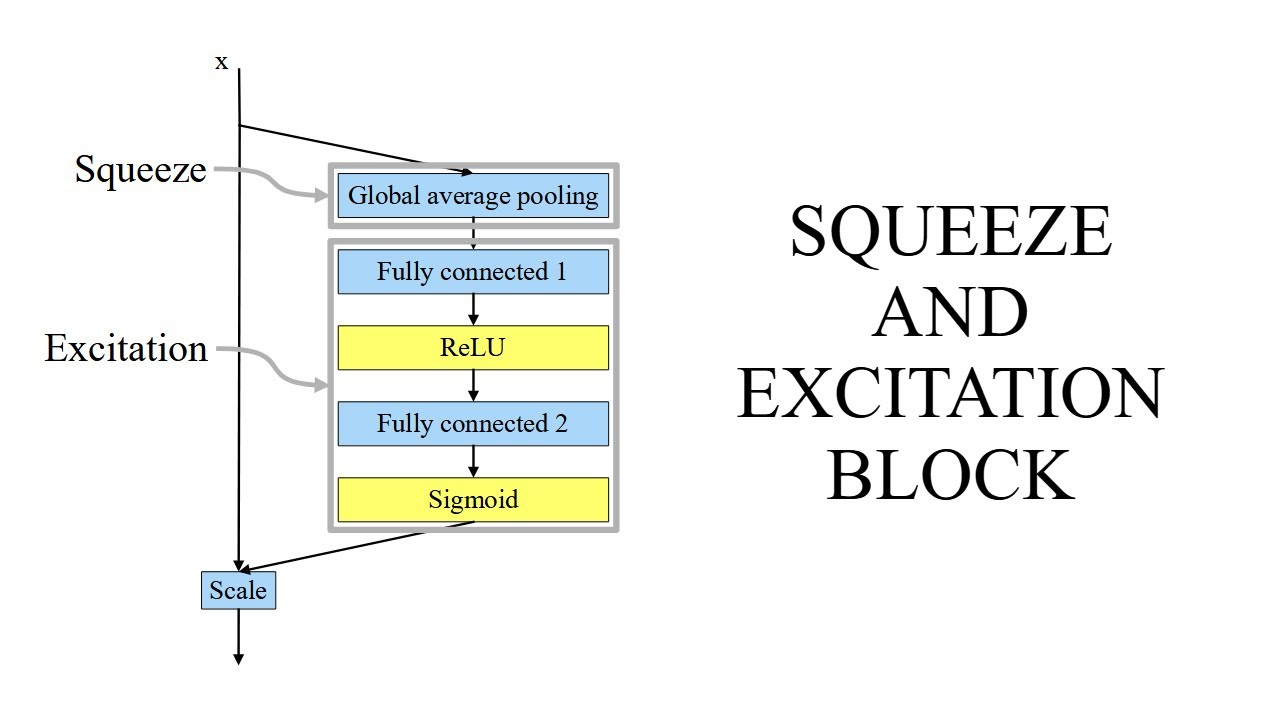

### Squeeze-and-Excitation (SE) Block

The Squeeze-and-Excitation (SE) block enhances the representational power of a neural network by explicitly modeling interdependencies between channels.

#### Key Functions:

1. **Squeeze**: 
   - Computes a channel descriptor by applying global average pooling, summarizing each channel's information.

2. **Excitation**: 
   - Uses two fully connected layers to generate channel weights, indicating the importance of each channel.

3. **Recalibration**: 
   - The original feature map is scaled by these weights, allowing the network to focus on more relevant features while suppressing less important ones.

Overall, SE blocks improve model performance by helping it learn to adaptively prioritize features.


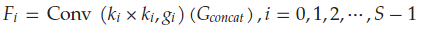

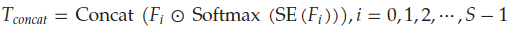

In [31]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=True)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        #Squeeze OP: Global Average Pooling
        b, c, _, _ = x.size()
        se = F.adaptive_avg_pool2d(x, 1).view(b, c)
        #Excitation OP
        se = F.relu(self.fc1(se))
        se = self.sigmoid(self.fc2(se))
        #Scale the input
        return x * se.view(b, c, 1, 1)



class FEEPSA(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(FEEPSA, self).__init__()
        
        self.conv2d = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=(1, 1), padding="same")  

        self.conv1 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3, 3, 1), padding=(1, 1, 0))  
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(5, 5, 3), padding=(2, 2, 1)) 
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(7, 7, 3), padding=(3, 3, 1))  
        self.conv4 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(7, 7, 5), padding=(3, 3, 2))  

        self.SE = SEBlock(in_channels=64 * 4)  #concatenated output channels

        self.conv2d2 = nn.Conv2d(in_channels=64*4, out_channels=192, kernel_size=(1, 1), padding=0)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        out0 = self.conv2d(x).unsqueeze(2) 

        out1 = self.conv1(out0)
        out2 = self.conv2(out0)
        out3 = self.conv3(out0)
        out4 = self.conv4(out0)
        
        out5 = torch.cat((out1, out2, out3, out4), dim=1)
        out5 = out5.squeeze(2)  # hna chofi more meme kayna wa7da unsqueez nseet win dertha

        se = self.SE(out5)
        
        se_softmax = self.softmax(se.view(se.size(0), se.size(1), -1))  #softmax on the last dimension
        se_softmax = se_softmax.view(se.size())  #reshape back to original for multiplication
        
        tconcat = torch.cat([out5 * se_softmax], dim=1)
        
        out6 = self.conv2d2(tconcat) + x
        
        return out6

> 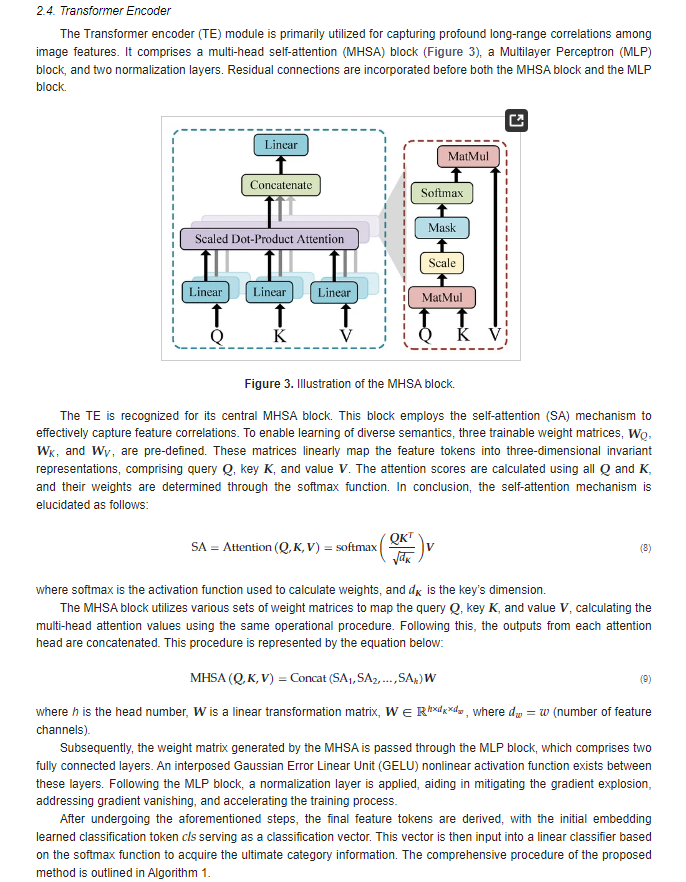

In [32]:

class TE(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(TE, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=192, nhead=8, dim_feedforward=512)  
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.norm1 = nn.LayerNorm(192)
        self.norm2 = nn.LayerNorm(192)
        self.fc1 = nn.Linear(192, 512)  
        self.fc2 = nn.Linear(512, 192)  
        self.gelu = nn.GELU()

    def forward(self, x):
        b, c, h, w = x.shape
        
        x = x.view(b, c, -1).permute(2, 0, 1)  

        out = self.transformer(x) 

        out = self.norm1(out + x)

        out = self.fc1(out)  
        out = self.gelu(out)
        out = self.fc2(out)  

        out = self.norm2(out + x)  

        out = out.mean(dim=0) 
        
        return out



In [51]:
class MHSA(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(MHSA, self).__init__()
        self.ms = MSCFE(num_classes, input_channels)  
        self.fe = FEEPSA(num_classes, 192)
        self.te = TE(num_classes, 192)
        self.fc = nn.Linear(192, num_classes)
        self.softmax = nn.Softmax(dim=1) 

    def forward(self, x):
        x = self.ms(x)  
        x = self.fe(x) 
        x = self.te(x) 
        x = self.fc(x)  
        out = self.softmax(x)  
        return out



model = MHSA(num_classes=len(unique_classes), input_channels=pca_bands)  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [46]:
print(len(unique_classes))

17


In [47]:
print(X_train.size(0))

8199


In [ ]:
for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    
    correct_train = 0
    total_train = 0
    
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        batch_x = batch_x.unsqueeze(2)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0

    model.eval()
    with torch.no_grad():
        outputs_val = model(X_test.unsqueeze(2))
        loss_val = criterion(outputs_val, y_test)
        
        _, predicted_val = torch.max(outputs_val.data, 1)
        total_val = y_test.size(0)
        correct_val = (predicted_val == y_test).sum().item()
        val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {loss_val.item():.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch [1/100], Train Loss: 2.1007, Train Accuracy: 65.03%, Validation Loss: 2.1496, Validation Accuracy: 81.56%
Epoch [2/100], Train Loss: 2.4248, Train Accuracy: 79.40%, Validation Loss: 2.1645, Validation Accuracy: 80.63%
Epoch [3/100], Train Loss: 2.1162, Train Accuracy: 80.63%, Validation Loss: 2.0997, Validation Accuracy: 84.59%
Epoch [4/100], Train Loss: 2.0149, Train Accuracy: 84.28%, Validation Loss: 2.1162, Validation Accuracy: 82.63%
Epoch [5/100], Train Loss: 2.0725, Train Accuracy: 85.85%, Validation Loss: 2.0752, Validation Accuracy: 86.49%
Epoch [6/100], Train Loss: 2.0770, Train Accuracy: 87.38%, Validation Loss: 2.0685, Validation Accuracy: 87.12%
